In [34]:
import numpy as np
%reload_ext autoreload
%autoreload 2 
# plots are displayed directly in the notebook as static images
%matplotlib inline 

import matplotlib.pyplot as plt
import random
import os
import glob
from PIL import Image
import sys
import time

from sklearn.metrics import confusion_matrix
import seaborn as sns

import torch
import torch.nn as nn 
import torch.optim as optim 
from torch.utils.data import DataLoader

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms 
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms

np.set_printoptions(precision=2)
use_gpu = torch.cuda.is_available() 

### Setting Random Seed for Reproducibility

To ensure reproducibility in experiments, it's essential to set the random seed for various libraries used in the project. Below is the code that sets the random seed for Python's `random`, `NumPy`, and `PyTorch`, ensuring that the results are deterministic across runs.

In [6]:
RANDOM_SEED = 1234
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Showing Classes in Dataset

This Python script shows the class names in the `train` directory.

In [7]:
sz = 224 
num_epochs = 50
batch_size = 32 
DATA_DIR = 'dataset'
train_dir = 'dataset/train'
valid_dir = 'dataset/val'
classes_name = os.listdir(train_dir)
num_classes = len(classes_name)
print(classes_name)

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


### Displaying Images from the Dataset

In this section, a specified number of images from each class in the dataset are randomly selected and displayed in a grid format.

The code below selects 5 images from each class in the dataset and displays them in a grid:


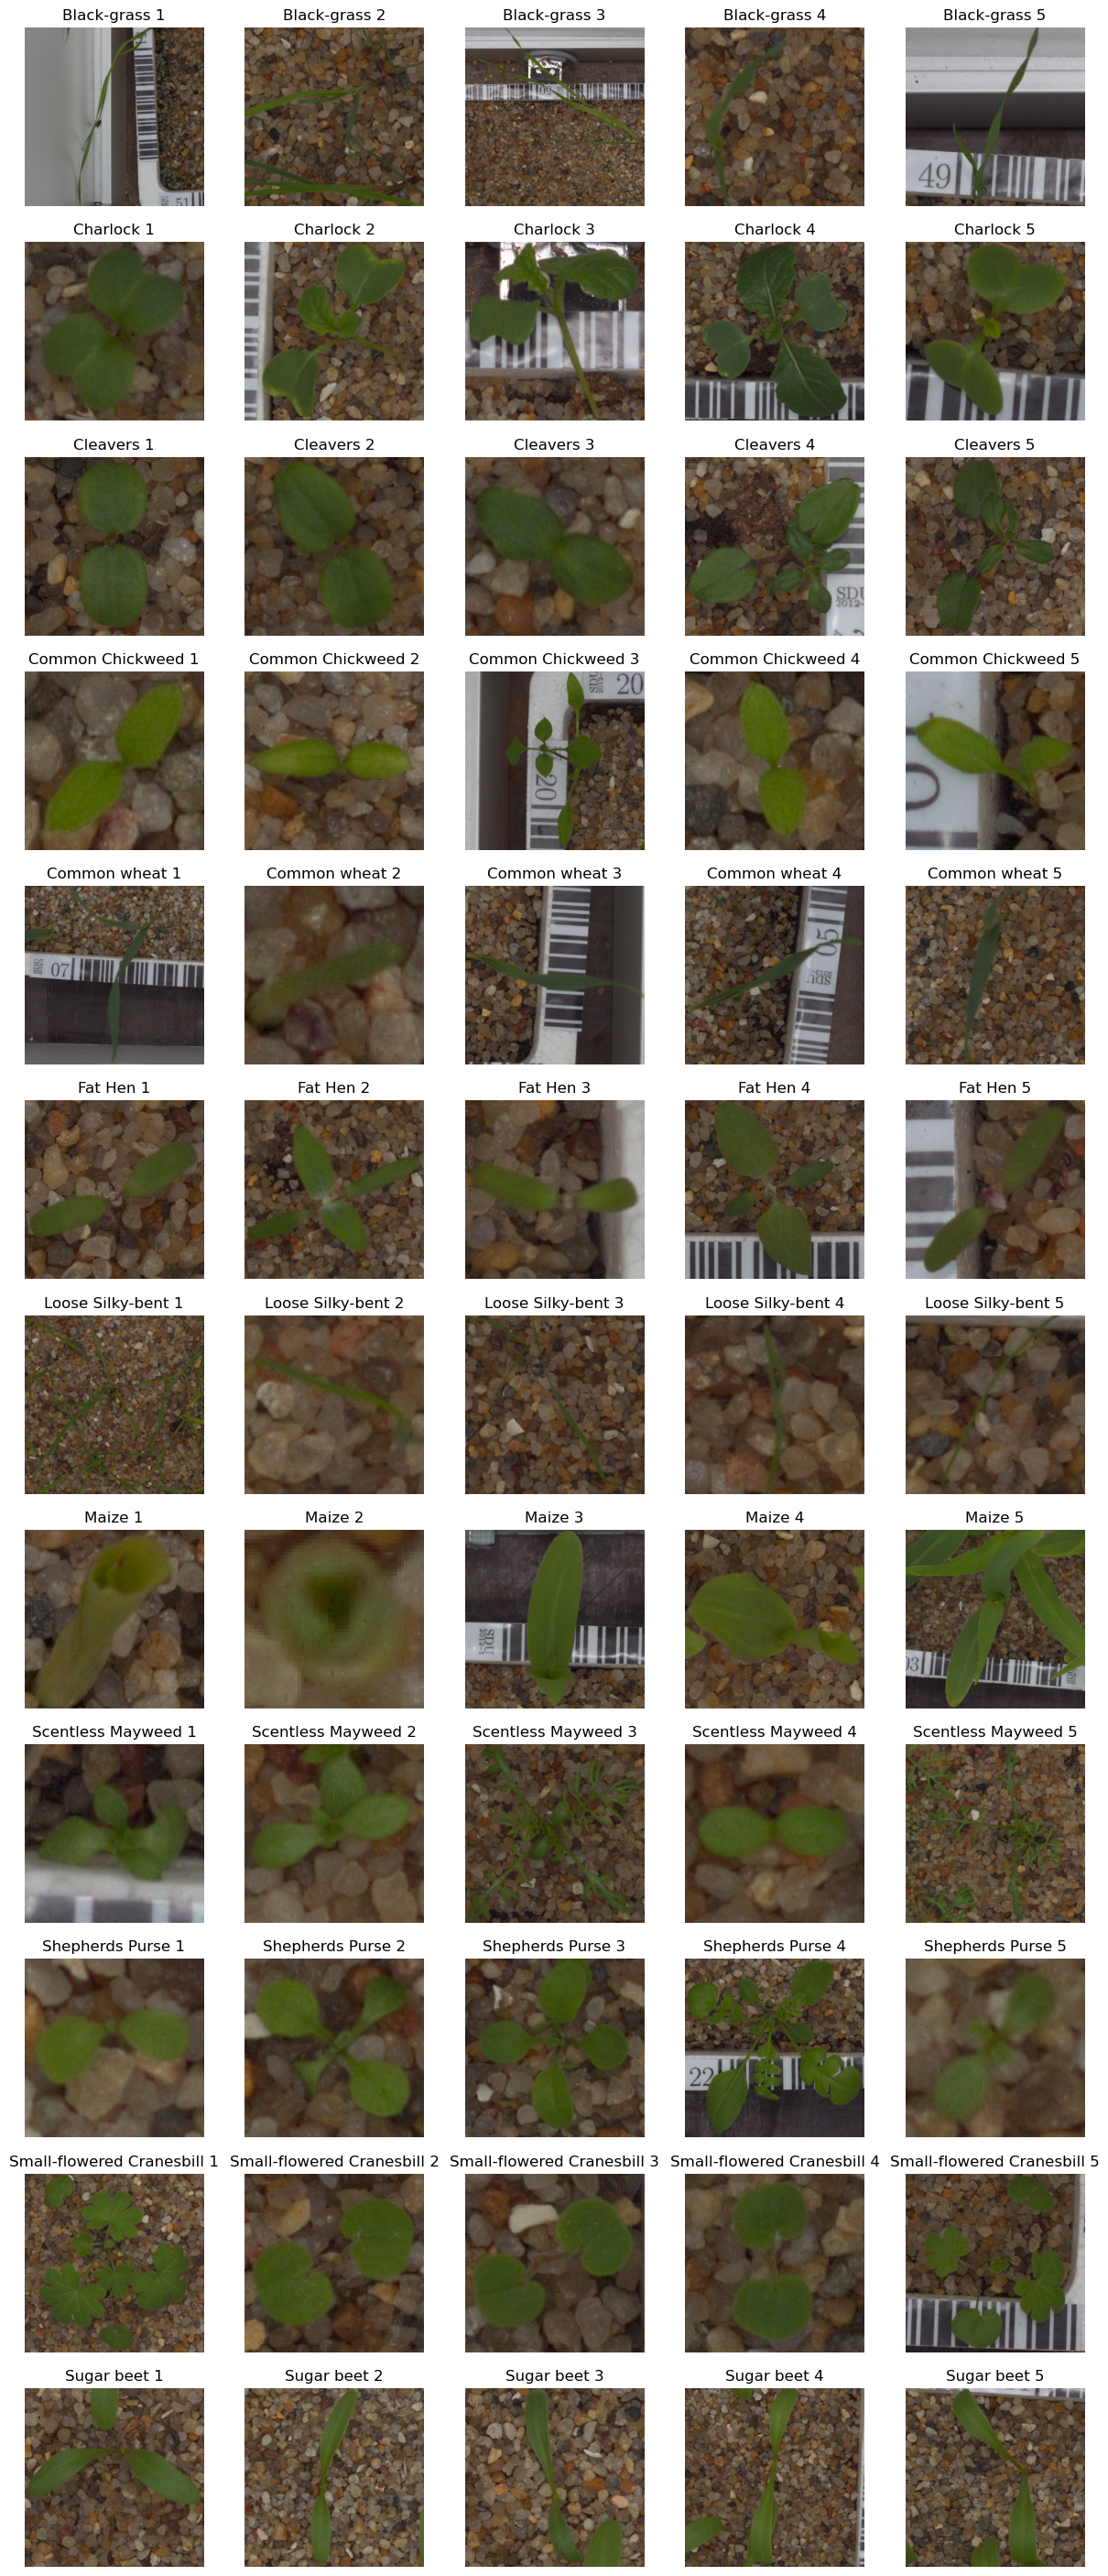

In [8]:
def grid_show_imgs(train_dir, classes_name, num_img_show =5):
    fig, axs = plt.subplots(len(classes_name), num_img_show, figsize=(15, len(classes_name) * 3))
    for i, class_name in enumerate(classes_name):
        class_name_dir = os.path.join(train_dir, class_name)
        images_list = [f for f in os.listdir(class_name_dir) if f.endswith(('jpg', 'png', 'jpeg'))]
        images_list_random = random.sample(images_list, num_img_show)
        for j, image in enumerate(images_list_random):
            image_dir = os.path.join(class_name_dir, image)
            img = Image.open(image_dir)
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            axs[i, j].set_title(f'{class_name} {j + 1}')
num_img_show = 5
grid_show_imgs(train_dir, classes_name, num_img_show)

### Data Splitting Code

This Python script splits a dataset into training and validation sets.

1. **Imports**: It uses `os`, `shutil`, and `train_test_split` from `sklearn.model_selection`.
2. **Function `split_data`**:
   - It takes two arguments: `data_dir` (training data directory) and `val_dir` (validation data directory).
   - The script creates the necessary directories and splits the data into 80% training and 20% validation.
   - It moves the validation images to the corresponding class folder in `val_dir`.

### Counting Class Samples in a Dataset Directory

The following function is designed to count the number of samples for each class in a dataset directory. This is particularly useful for inspecting the distribution of data across different classes, which can help identify imbalances in the dataset.

In [9]:
def count_class_samples(data_dir):
    """
    Counts the number of samples for each class in a dataset directory.

    Args:
        data_dir (str): Path to the dataset directory. Each subdirectory represents a class.

    Returns:
        dict: A dictionary with class names as keys and number of samples as values.
    """
    class_counts = {}
    for folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder)
        if os.path.isdir(folder_path):  # Check if it's a directory
            class_counts[folder] = len(os.listdir(folder_path))  # Count files in the directory
    return class_counts

train_counts = count_class_samples(train_dir)
valid_counts = count_class_samples(valid_dir)

print("Train Class Counts:", train_counts)
print("Valid Class Counts:", valid_counts)

Train Class Counts: {'Black-grass': 210, 'Charlock': 312, 'Cleavers': 229, 'Common Chickweed': 488, 'Common wheat': 176, 'Fat Hen': 380, 'Loose Silky-bent': 523, 'Maize': 176, 'Scentless Mayweed': 412, 'Shepherds Purse': 184, 'Small-flowered Cranesbill': 396, 'Sugar beet': 308}
Valid Class Counts: {'Black-grass': 53, 'Charlock': 78, 'Cleavers': 58, 'Common Chickweed': 123, 'Common wheat': 45, 'Fat Hen': 95, 'Loose Silky-bent': 131, 'Maize': 45, 'Scentless Mayweed': 104, 'Shepherds Purse': 47, 'Small-flowered Cranesbill': 100, 'Sugar beet': 77}


### Creating and Displaying Data Loaders

The following code creates training and validation data loaders using the `create_dataloaders` function. It also prints the number of samples in the training and validation datasets.

In [40]:
def create_dataloaders(train_dir, val_dir, sz=224, batch_size=32):
    # Define the image transformations for train and validation data
    train_transform = transforms.Compose([
        transforms.RandomAffine(degrees=0, translate=(0.3, 0.3)),
        transforms.Resize((sz, sz)),       # Resize images to 224x224
        transforms.RandomHorizontalFlip(),   # Random horizontal flip for data augmentation
        transforms.RandomRotation(180),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust colors
        transforms.ToTensor(),               # Convert images to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
    ])

    val_transform = transforms.Compose([
        transforms.Resize((sz, sz)),       # Resize images to 224x224
        transforms.ToTensor(),               # Convert images to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
    ])

    # Load the datasets using ImageFolder
    train_dataset = ImageFolder(root=train_dir, transform=train_transform)
    val_dataset = ImageFolder(root=val_dir, transform=val_transform)

    # Create DataLoader for training and validation sets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2, shuffle=False, pin_memory=True)

    print("DataLoaders for train and validation sets created!")

    return train_loader, val_loader


In [36]:
train_dl, val_dl = create_dataloaders(train_dir, valid_dir, sz, batch_size)

print("Training data:", len(train_dl.dataset))
print("Validation data:", len(val_dl.dataset))

DataLoaders for train and validation sets created!
Training data: 3794
Validation data: 956


### Visualizing Class Distribution in the Training Dataset

This code snippet generates a bar chart to display the class distribution in the training dataset, helping to identify any imbalance in the dataset. Below are the steps and details about the implementation:

#### Purpose:

This visualization helps to:
- Identify whether the dataset is balanced across all classes.
- Highlight any significant discrepancies in class counts, which may require handling during model training (e.g., oversampling, undersampling, or class weighting).

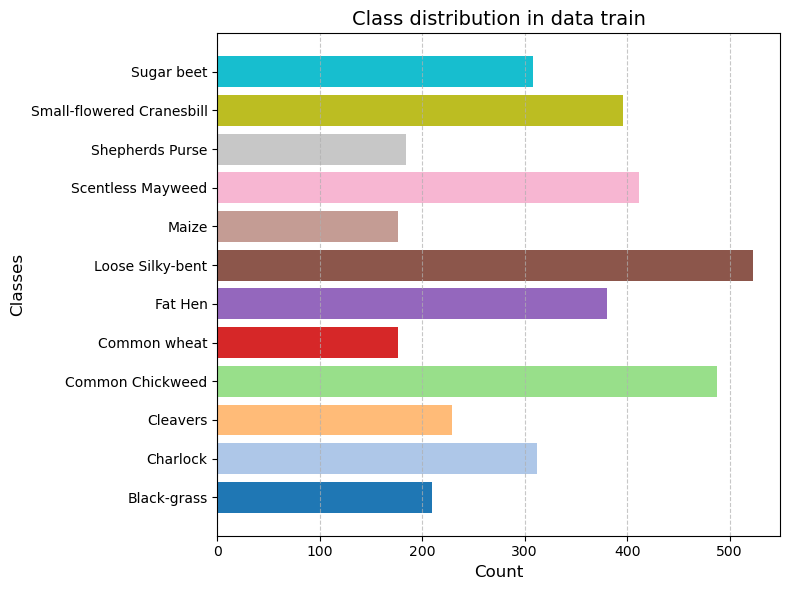

In [25]:
# Extracting keys (class names) and values (counts) from the dictionary
classes = list(train_counts.keys())
counts = list(train_counts.values())

# Generating a unique color for each class
colors = [plt.cm.tab20(i / len(classes)) for i in range(len(classes))]

# Plotting the horizontal bar chart
plt.figure(figsize=(8, 6))  # Set the figure size
plt.barh(classes, counts, color=colors)  # Create a horizontal bar chart with different colors

# Adding labels, title, and customizing the plot
plt.xlabel('Count', fontsize=12)  # Label for the x-axis (horizontal axis)
plt.ylabel('Classes', fontsize=12)  # Label for the y-axis (vertical axis)
plt.title('Class distribution in data train', fontsize=14)  # Title of the plot
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add gridlines on the x-axis

# Adjust layout to ensure labels fit well
plt.tight_layout()

# Display the plot
plt.show()


### Model Initialization and Transfer Learning

In this section, we initialize a pre-trained **ResNet50** model using **Transfer Learning**. Transfer Learning allows us to leverage a model that has been trained on a large dataset (like ImageNet) and fine-tune it for our specific task, which significantly reduces the training time and can lead to better performance, especially with limited data.

In [26]:
def load_pretrained_resnet101(model_path=None, num_classes=10):
    if model_path is None:
        model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
       # for param in model.parameters():
           # param.require_grad = False
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    else:
        model = models.resnet101(weights=None)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        model.load_state_dict(torch.load(model_path))
    
    if use_gpu:
        model = model.cuda()
        
    return model

model = load_pretrained_resnet101(model_path=None, num_classes=num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Loss Function and Optimizer Setup

In this section, we define the **loss function** and the **optimizer** for training the model. These components are crucial for guiding the model's learning process during training.

In [27]:
criterion = nn.CrossEntropyLoss() # Define the loss function (Cross-Entropy Loss) 
optimizer = optim.Adam(model.fc.parameters(), lr=0.01) # Define the optimizer (Adam optimizer) for fine-tuning the fully connected layer
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) # Decreases the learning rate by a factor of gamma every 

### Training Pipeline with Early Stopping and Loss Monitoring

This script provides a structured training framework in PyTorch, including early stopping, loss tracking, and learning rate scheduling.

---


#### **1. EarlyStopping Class**
- Stops training if validation accuracy doesn't improve for `patience` epochs.
- Saves the best model weights (`best_model_wts`).

---

#### **2. Training One Epoch**
- Trains the model for one epoch, tracks loss and accuracy, and updates weights.
- Reports batch-wise progress.

---

#### **3. Model Validation**
- Evaluates the model on validation data, calculating loss and accuracy.
- Tracks validation loss for early stopping.

---

#### **4. Training Loop**
- Orchestrates training and validation across epochs.
- Features:
  - Learning rate scheduling.
  - Early stopping to avoid overfitting.
  - Automatic saving of the best model.
  - Records training/validation losses for analysis.

In [29]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        """
        Initialize EarlyStopping.

        Args:
            patience (int): Number of epochs with no improvement to wait before stopping.
            delta (float): Minimum change to qualify as an improvement.
        """
        self.patience = patience  # Number of epochs to wait for improvement
        self.delta = delta  # Minimum change to qualify as an improvement
        self.counter = 0  # Counter for epochs with no improvement
        self.best_score = None  # Best validation score
        self.early_stop = False  # Flag to stop training
        self.best_model_wts = None  # Best model weights

    def __call__(self, val_score, model):
        """
        Check if early stopping should be triggered.

        Args:
            val_score (float): The validation score (e.g., accuracy or loss).
            model (torch.nn.Module): The model to save the best weights.
        """
        if self.best_score is None:
            self.best_score = val_score
        elif val_score < self.best_score - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True  # Stop training if no improvement
        else:
            self.best_score = val_score
            self.counter = 0
            self.best_model_wts = model.state_dict().copy()  # Save the best model weights

def train_one_epoch(model, dataloader, criterion, optimizer, device, train_losses):
    """
    Train the model for one epoch.

    Args:
        model (torch.nn.Module): The model to train.
        dataloader (torch.utils.data.DataLoader): The data loader for training data.
        criterion (torch.nn.Module): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer.
        device (torch.device): The device to run the model on.
        train_losses (list): List to store training losses.

    Returns:
        model (torch.nn.Module): The trained model.
    """
    model.train()

    steps = len(dataloader.dataset) // dataloader.batch_size

    running_loss = 0.0
    running_corrects = 0

    for i, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Update parameters
        optimizer.step()

        # Statistics
        running_loss = (running_loss * i + loss.item()) / (i + 1)
        running_corrects += torch.sum(outputs.argmax(1) == labels)

        # Report progress
        sys.stdout.flush()
        sys.stdout.write("\r  Step %d/%d | Loss: %.5f" % (i, steps, loss.item()))

    epoch_loss = running_loss
    epoch_acc = running_corrects / len(dataloader.dataset)

    # Add the loss to the train_losses list
    train_losses.append(epoch_loss)

    sys.stdout.flush()
    print('\r{} Loss: {:.5f} Acc: {:.5f}'.format('  train', epoch_loss, epoch_acc))

    return model

def validate_model(model, dataloader, criterion, device, valid_losses):
    """
    Validate the model after training.

    Args:
        model (torch.nn.Module): The model to evaluate.
        dataloader (torch.utils.data.DataLoader): The data loader for validation data.
        criterion (torch.nn.Module): The loss function.
        device (torch.device): The device to run the model on.
        valid_losses (list): List to store validation losses.

    Returns:
        epoch_acc (float): The validation accuracy for the current epoch.
    """
    model.eval()

    steps = len(dataloader.dataset) // dataloader.batch_size

    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss = (running_loss * i + loss.item()) / (i + 1)
            running_corrects += torch.sum(outputs.argmax(1) == labels)

            # Report progress
            sys.stdout.flush()
            sys.stdout.write("\r  Step %d/%d | Loss: %.5f" % (i, steps, loss.item()))

    epoch_loss = running_loss
    epoch_acc = running_corrects / len(dataloader.dataset)

    # Add the loss to the valid_losses list
    valid_losses.append(epoch_loss)

    sys.stdout.flush()
    print('\r{} Loss: {:.5f} Acc: {:.5f}'.format('  valid', epoch_loss, epoch_acc))

    return epoch_acc

def train_model(model, train_dl, valid_dl, criterion, optimizer, device,
                scheduler=None, num_epochs=10, patience=5):
    """
    Train the model over multiple epochs and validate it.

    Args:
        model (torch.nn.Module): The model to train.
        train_dl (torch.utils.data.DataLoader): Data loader for training data.
        valid_dl (torch.utils.data.DataLoader): Data loader for validation data.
        criterion (torch.nn.Module): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer.
        device (torch.device): The device to run the model on.
        scheduler (torch.optim.lr_scheduler, optional): The learning rate scheduler.
        num_epochs (int): Number of epochs to train the model.
        patience (int): Number of epochs to wait for improvement before stopping.

    Returns:
        model (torch.nn.Module): The trained model.
        train_losses (list): List of training losses for each epoch.
        valid_losses (list): List of validation losses for each epoch.
    """
    if not os.path.exists('models'):
        os.mkdir('models')

    device = device or torch.device('cpu')

    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    num_epoch_save = 10

    # Create lists to store losses
    train_losses = []
    valid_losses = []

    early_stopping = EarlyStopping(patience=patience, delta=0)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Train and validate the model
        model = train_one_epoch(model, train_dl, criterion, optimizer, device, train_losses)
        val_acc = validate_model(model, valid_dl, criterion, device, valid_losses)

        if scheduler is not None:
            scheduler.step()

        # Check for early stopping
        early_stopping(val_acc, model)

        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

        # Deep copy the model if it improves
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict().copy()
            torch.save(best_model_wts, "./models/epoch-{}-acc-{:.5f}.pth".format(epoch, best_acc))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))

    # Load the best model weights
    model.load_state_dict(best_model_wts)

    # Return the lists of losses for later plotting
    return model, train_losses, valid_losses


In [30]:
model, train_losses, valid_losses = train_model(model, train_dl, val_dl, criterion, optimizer, device, scheduler, num_epochs=num_epochs)

Epoch 1/50
----------
  train Loss: 1.61901 Acc: 0.49446
  valid Loss: 1.01733 Acc: 0.68201

Epoch 2/50
----------
  train Loss: 1.06275 Acc: 0.65867
  valid Loss: 0.85157 Acc: 0.73954

Epoch 3/50
----------
  train Loss: 0.96578 Acc: 0.68898
  valid Loss: 0.84805 Acc: 0.72699

Epoch 4/50
----------
  train Loss: 0.90024 Acc: 0.71455
  valid Loss: 0.91382 Acc: 0.75105

Epoch 5/50
----------
  train Loss: 0.90471 Acc: 0.72852
  valid Loss: 0.81004 Acc: 0.75314

Epoch 6/50
----------
  train Loss: 0.93957 Acc: 0.71692
  valid Loss: 0.71920 Acc: 0.77197

Epoch 7/50
----------
  train Loss: 0.97621 Acc: 0.71745
  valid Loss: 0.61925 Acc: 0.80230

Epoch 8/50
----------
  train Loss: 0.87171 Acc: 0.74196
  valid Loss: 0.70526 Acc: 0.79079

Epoch 9/50
----------
  train Loss: 0.94494 Acc: 0.72746
  valid Loss: 0.83396 Acc: 0.76674

Epoch 10/50
----------
  train Loss: 0.87455 Acc: 0.74750
  valid Loss: 0.70246 Acc: 0.78243

Epoch 11/50
----------
  train Loss: 0.74389 Acc: 0.77227
  valid Los

## Visualizing Training and Validation Loss

The following code snippet plots the training and validation loss over epochs to evaluate the model's performance during training. This visualization helps identify whether the model is overfitting, underfitting, or learning effectively.

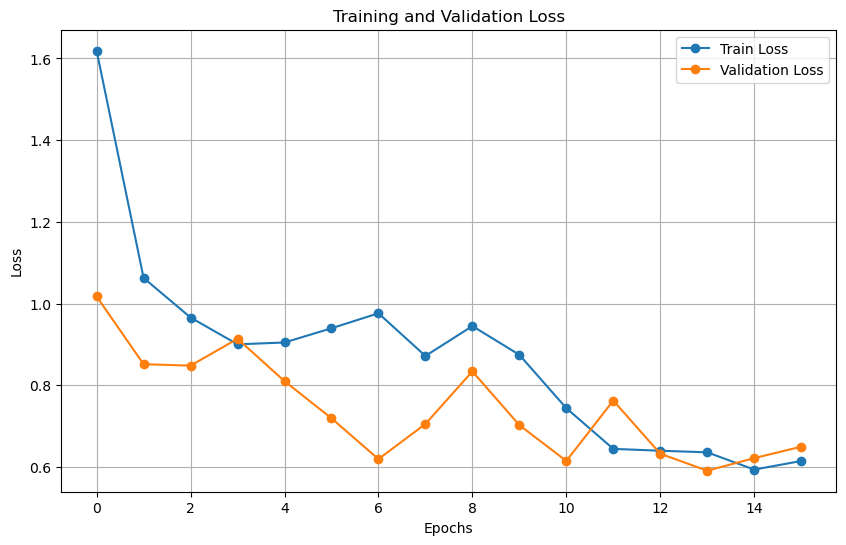

In [31]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(valid_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()


### Confusion Matrix

A **confusion matrix** is a performance measurement tool for machine learning classification tasks. It helps to understand how well a model is performing by comparing the predicted labels with the actual labels. The matrix contains counts of actual versus predicted classifications, allowing us to analyze which classes are correctly or incorrectly classified.

C:\Users\Sepehr\AppData\Local\Temp\ipykernel_19360\2398346826.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


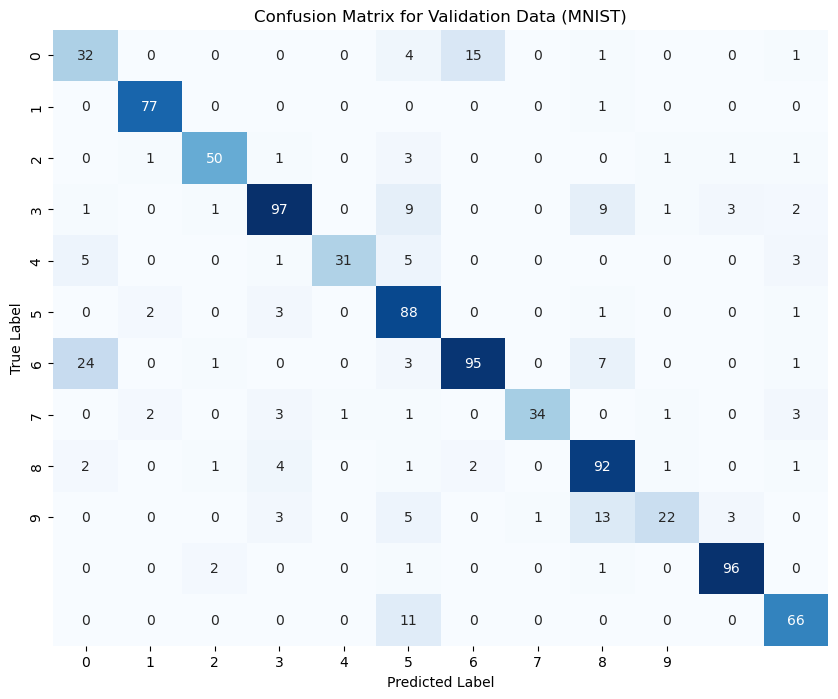

In [41]:
model = load_pretrained_resnet101(model_path='./models/epoch-10-acc-0.81590.pth', num_classes=num_classes)
model.to(device) 
model.eval()

# Initialize variables to store predictions and true labels
all_preds = []
all_labels = []

# Disable gradient computation for inference
with torch.no_grad():
    for images, labels in val_dl:
        # Move data to device (GPU/CPU)
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Get the predicted class (index with max probability)
        _, preds = torch.max(outputs, 1)
        
        # Store predictions and labels
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.title('Confusion Matrix for Validation Data (MNIST)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
